In [2]:
import pandas as pd
import numpy as np
import torch
import glob
import os
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import scipy.ndimage
from pvlib import spectrum, solarposition, irradiance, atmosphere


# Plotting

📄 Loading: dat/train/tc_2017-07-15_full_day.csv


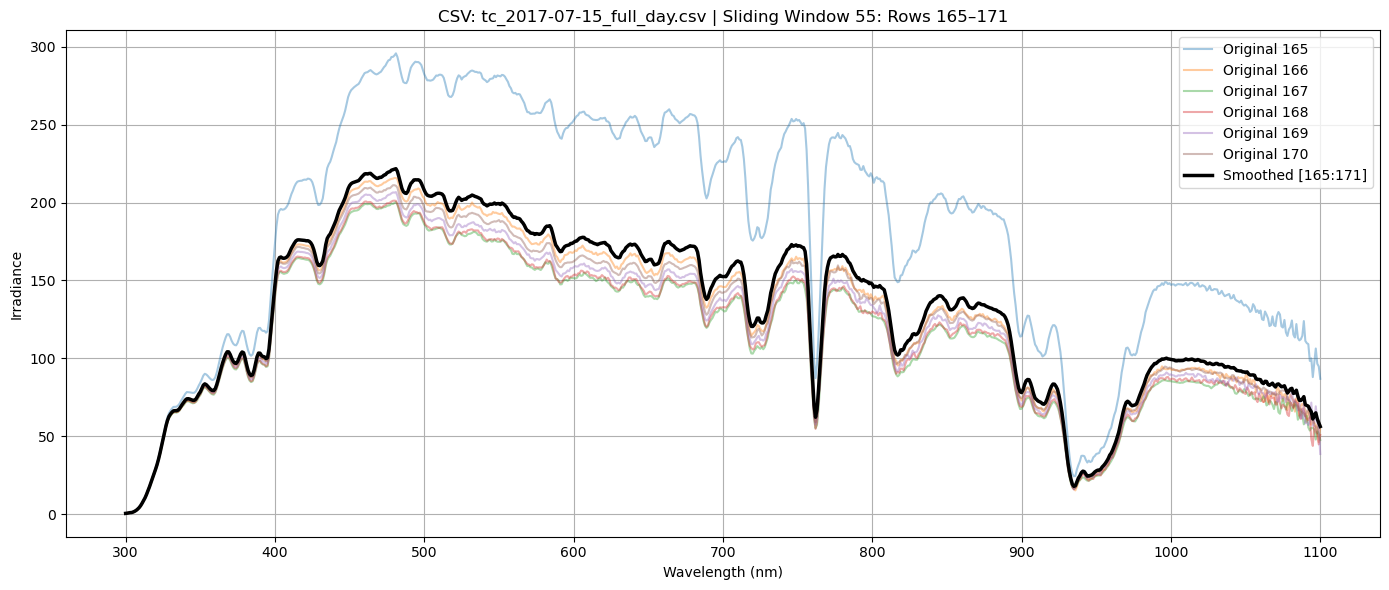

[ 17.1   65.51  77.64 ...  -7.32 -16.84  16.23]


In [3]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

def sliding_window_average(tensor, window_size=5, stride=2):
    N, D = tensor.shape
    smoothed = []
    for start in range(0, N - window_size + 1, stride):
        window = tensor[start:start + window_size]
        avg = window.mean(dim=0)
        smoothed.append(avg)
    return torch.stack(smoothed)

# 🗂 Load a single CSV from dat/train
csv_file = sorted(glob.glob('dat/train/*.csv'))[0]  # You can change the [0] to another file index
print(f"📄 Loading: {csv_file}")

# 🧠 Load only a slice of the file for speed
max_rows = 8000
df = pd.read_csv(csv_file, nrows=max_rows)

# 🧼 Drop datetime column and convert to tensor
datetime_col = 'dt_UTC01_NoDLS'
if datetime_col in df.columns:
    df = df.drop(columns=[datetime_col])
data_tensor = torch.tensor(df.values, dtype=torch.float32)

# 🔢 Windowing parameters
window_index = 55
window_size = 6
stride = 3

# 🎯 Compute which rows are used in this window
start = window_index * stride
end = start + window_size

# ⛓ Get the original window
original_window = data_tensor[start:end]

# 🧮 Apply smoothing
smoothed_tensor = sliding_window_average(data_tensor, window_size=window_size, stride=stride)
smoothed_window = smoothed_tensor[window_index]

# 🧭 Wavelengths (300–1100 nm)
wavelengths = torch.linspace(300, 1100, data_tensor.shape[1]).numpy()

# 🎨 Plot
plt.figure(figsize=(14, 6))
for i in range(original_window.shape[0]):
    plt.plot(wavelengths, original_window[i].numpy(), alpha=0.4, label=f'Original {start+i}')
plt.plot(wavelengths, smoothed_window.numpy(), color='black', linewidth=2.5, label=f'Smoothed [{start}:{end}]')
plt.title(f"CSV: {os.path.basename(csv_file)} | Sliding Window {window_index}: Rows {start}–{end}")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

broadband_irradiance = np.trapz(df.values, x=df.columns.astype(float), axis=1)
broadband_irradiance = np.sum(df.values, axis=1)
print(broadband_irradiance)


In [4]:
print(broadband_irradiance[666])

140692.57000000024


In [7]:

def count_sign_changes(diff_row, magnitude_threshold=0.5):
    """Count sign changes in a row, but only if the difference magnitude exceeds the threshold."""
    diffs = np.array(diff_row)
    signs = np.sign(diffs)

    # Apply magnitude filter
    large_enough = np.abs(diffs) >= magnitude_threshold
    filtered_signs = signs * large_enough  # zeros out small diffs

    # Remove zero entries (no sign/no change)
    filtered_signs = filtered_signs[filtered_signs != 0]

    # Count sign changes between adjacent filtered diffs
    sign_changes = np.count_nonzero(np.diff(filtered_signs) != 0)
    return sign_changes


def sliding_window_daywise(df, datetime_col, window_size=5, stride=3):
    """
    For each day, apply sliding window averaging aligned to the day's start and end.
    Returns:
    - DataFrame of smoothed spectra
    - List of datetime intervals (as strings)
    """
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col)
    df.set_index(datetime_col, inplace=True)

    result_rows = []
    interval_labels = []

    for day, day_df in df.groupby(df.index.date):
        timestamps = day_df.index.to_list()
        values = day_df.values
        if len(values) < window_size:
            continue
        for start in range(0, len(values) - window_size + 1, stride):
            window = values[start:start + window_size]
            avg = window.mean(axis=0)

            start_dt = timestamps[start]
            end_dt = timestamps[start + window_size - 1]
            label = f"{start_dt.strftime('%Y-%m-%d %H:%M')} – {end_dt.strftime('%H:%M')}"

            result_rows.append(avg)
            interval_labels.append(label)

    smoothed_df = pd.DataFrame(result_rows)
    smoothed_df['interval'] = interval_labels
    return smoothed_df


def load_or_preprocess(directory_path, cache_path, sum_threshold=50, max_sign_changes=75, min_allowed_value=-0.1,
                       datetime_col='dt_UTC01_NoDLS', window_size=5, stride=3, max_val=4):
    if os.path.exists(cache_path):
        print(f"🔄 Loading cached tensor from {cache_path}")
        return torch.load(cache_path), None  # Return None for df to avoid reprocessing

    print(f"📦 Preprocessing CSVs in {directory_path} ...")
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    tensors = []
    dfs = []

    total_initial = 0
    total_final = 0

    for fp in csv_files:
        try:
            df = pd.read_csv(fp)
            if datetime_col not in df.columns:
                print(f"Skipping {fp}: missing datetime column '{datetime_col}'")
                continue

            total_initial += len(df)

            # Sliding window averaging
            smoothed_df = sliding_window_daywise(df, datetime_col=datetime_col,
                                                 window_size=window_size, stride=stride)
            

            interval_col = smoothed_df['interval']
            smoothed_df = smoothed_df.drop(columns=['interval'])

            # Set negative values to zero
            smoothed_df[smoothed_df < 0] = 0

            # Apply filters
            smoothed_df = smoothed_df[smoothed_df.sum(axis=1) >= sum_threshold]
            smoothed_df = smoothed_df[(smoothed_df >= min_allowed_value).all(axis=1)]
            smoothed_df = smoothed_df[smoothed_df.max(axis=1) >= max_val]

            # Optional: Sign change filter (disabled here)
            # diffs = smoothed_df.diff(axis=1).iloc[:, 1:]
            # sign_changes = diffs.apply(lambda row: count_sign_changes(row, magnitude_threshold=0.2), axis=1)
            # smoothed_df = smoothed_df[sign_changes <= max_sign_changes]

            if not smoothed_df.empty:

                filtered_intervals = interval_col.loc[smoothed_df.index]
                smoothed_df['interval'] = filtered_intervals
                t = torch.tensor(smoothed_df.drop(columns=['interval']).values, dtype=torch.float32)
                tensors.append(t)
                dfs.append(smoothed_df)
                total_final += len(smoothed_df)

        except Exception as e:
            print(f"Skipping {fp}: {e}")

    if not tensors:
        raise RuntimeError(f"No data found in {directory_path} after filtering.")

    # Final concatenation
    data = torch.cat(tensors, dim=0)
    full_df = pd.concat(dfs, axis=0).reset_index(drop=True)

    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    torch.save(data, cache_path)

    print(f"Data points before filtering: {total_initial}")
    print(f"Data points after filtering:  {total_final}")
    print(f"Preprocessed and saved to {cache_path}, shape = {data.shape}")
    
    return data, full_df


train_tensor, train_df = load_or_preprocess('dat/train', 'cached/train.pt', sum_threshold=10000)
val_tensor, val_df   = load_or_preprocess('dat/val',   'cached/val.pt',   sum_threshold=10000)
test_tensor, test_df  = load_or_preprocess('dat/test',  'cached/test.pt',  sum_threshold=10000)




📦 Preprocessing CSVs in dat/train ...
Skipping dat/train/tc_2020-07-25_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-05-01_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-07-12_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-07-04_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-09-03_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-08-11_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-08-22_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-06-02_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-08-16_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-06-30_full_day.csv: missing datetime column 'dt_UTC01_NoDLS'
Skipping dat/train/tc_2020-06-04_full_day.csv: missing datetime column 'dt_UTC01_N

In [8]:
train_tensor = train_tensor/1000
test_tensor = test_tensor/1000
val_tensor = val_tensor/1000

In [80]:
train_df.shape

(298, 801)

In [71]:
average_sum = test_tensor.sum(dim=1).mean().item()
print(f"Average of row sums: {average_sum:.4f}")


Average of row sums: 248634.0312


# Old one

In [ ]:
def count_sign_changes(diff_row, magnitude_threshold=0.5):
    """Count sign changes in a row, but only if the difference magnitude exceeds the threshold."""
    diffs = np.array(diff_row)
    signs = np.sign(diffs)

    # Apply magnitude filter
    large_enough = np.abs(diffs) >= magnitude_threshold
    filtered_signs = signs * large_enough  # zeros out small diffs

    # Remove zero entries (no sign/no change)
    filtered_signs = filtered_signs[filtered_signs != 0]

    # Count sign changes between adjacent filtered diffs
    sign_changes = np.count_nonzero(np.diff(filtered_signs) != 0)
    return sign_changes


def load_or_preprocess(directory_path, cache_path, sum_threshold=50, max_sign_changes=75, min_allowed_value=-0.1):
    """
    Loads from cache if available; otherwise, reads CSVs, filters out:
    - rows with sum < sum_threshold
    - rows containing values < min_allowed_value
    - rows with too many significant sign changes (sign change + |Δ| > 0.2)
    Saves valid data as a tensor to cache_path.
    """
    if os.path.exists(cache_path):
        print(f"🔄 Loading cached tensor from {cache_path}")
        return torch.load(cache_path)

    print(f"📦 Preprocessing CSVs in {directory_path} ...")
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    tensors = []

    for fp in csv_files:
        try:
            df = pd.read_csv(fp)
            df = df.drop(columns='dt_UTC01_NoDLS', errors='ignore')
            df = df.apply(pd.to_numeric, errors='coerce').dropna()

            # Filter 1: sum threshold
            df = df[df.sum(axis=1) >= sum_threshold]

            # Filter 2: discard rows with any value < min_allowed_value
            df = df[(df >= min_allowed_value).all(axis=1)]

            if not df.empty:
                # Filter 3: significant sign changes
                diffs = df.diff(axis=1).iloc[:, 1:]
                sign_changes = diffs.apply(lambda row: count_sign_changes(row, magnitude_threshold=0.2), axis=1)
                df = df[sign_changes <= max_sign_changes]

                if not df.empty:
                    t = torch.tensor(df.values, dtype=torch.float32)
                    tensors.append(t)
        except Exception as e:
            print(f"  ⚠️ Skipping {fp}: {e}")

    if not tensors:
        raise RuntimeError(f"No data found in {directory_path} after filtering.")

    data = torch.cat(tensors, dim=0)
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    torch.save(data, cache_path)
    print(f"✅ Preprocessed and saved to {cache_path}, shape = {data.shape}")
    return data

# Usage:
train_tensor = load_or_preprocess('dat/train', 'cached/train.pt', sum_threshold=500)
val_tensor   = load_or_preprocess('dat/val',   'cached/val.pt',   sum_threshold=500)
test_tensor  = load_or_preprocess('dat/test',  'cached/test.pt',  sum_threshold=500)

📦 Preprocessing CSVs in dat/train ...
✅ Preprocessed and saved to cached/train.pt, shape = torch.Size([70066, 801])
📦 Preprocessing CSVs in dat/val ...


KeyboardInterrupt: 

In [89]:
print(f"train_tensor.shape: {train_tensor.shape}")
print(f"test_tensor.shape: {test_tensor.shape}")
print(f"val_tensor.shape: {val_tensor.shape}")

train_tensor.shape: torch.Size([401718, 721])
test_tensor.shape: torch.Size([128300, 721])
val_tensor.shape: torch.Size([117201, 721])


# do not run 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = train_tensor.to(device)
print(f"Tensor is on: {data_tensor.device}")

Tensor is on: cuda:0


In [4]:
print("Tensor shape:", data_tensor.shape)  # (N, 801), where N is the number of time stamps

Tensor shape: torch.Size([935847, 801])


In [5]:
# # Min-max normalization
min_vals = data_tensor.min(dim=0, keepdim=True).values
max_vals = data_tensor.max(dim=1, keepdim=True).values

# Avoid divide-by-zero by adding a small epsilon
normalized_tensor = (data_tensor) / (max_vals + 1e-8)

# normalized_tensor = data_tensor



# Wrap data into a TensorDataset and DataLoader
dataset = TensorDataset(normalized_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [6]:
max_vals.shape

torch.Size([935847, 1])

# RUN HERE

In [9]:
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),

            nn.Linear(1000, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),


            nn.Linear(600, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),

            nn.Linear(300, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),

            nn.Linear(100, 6)
        )
        self.decoder = nn.Sequential(
            nn.Linear(6, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),

            nn.Linear(100, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),

            nn.Linear(300, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),

            nn.Linear(600, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),

            nn.Linear(1000, input_dim)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder (EXACT dimensions)
        self.enc_conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2)  # 801 → 401
        self.enc_bn1 = nn.BatchNorm1d(32)
        
        self.enc_conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)  # 401 → 201
        self.enc_bn2 = nn.BatchNorm1d(64)
        
        self.enc_conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)  # 201 → 101
        self.enc_bn3 = nn.BatchNorm1d(128)
        
        self.enc_conv4 = nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2)  # 101 → 51
        self.enc_bn4 = nn.BatchNorm1d(256)
        
        # Bottleneck (6D)
        self.bottleneck_conv = nn.Conv1d(256, 6, kernel_size=5, stride=2, padding=2)  # 51 → 26
        self.bottleneck_fc = nn.Linear(26*6, 6)
        
        # Decoder (EXACT reverse with correct channel counts)
        self.dec_fc = nn.Linear(6, 26*6)
        self.dec_deconv1 = nn.ConvTranspose1d(6, 256, kernel_size=5, stride=2, padding=2, output_padding=1)  # 26 → 51
        
        # Skip connection layers (input channels = decoder channels + skip channels)
        self.dec_conv1 = nn.ConvTranspose1d(512, 128, kernel_size=5, stride=2, padding=2, output_padding=1)  # 51 → 101
        self.dec_conv2 = nn.ConvTranspose1d(256, 64, kernel_size=5, stride=2, padding=2, output_padding=1)  # 101 → 201
        self.dec_conv3 = nn.ConvTranspose1d(128, 32, kernel_size=5, stride=2, padding=2, output_padding=1)  # 201 → 401
        self.dec_conv4 = nn.ConvTranspose1d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1)  # 401 → 801
        
        # Batch norms
        self.dec_bn1 = nn.BatchNorm1d(128)
        self.dec_bn2 = nn.BatchNorm1d(64)
        self.dec_bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_bn1(self.enc_conv1(x)))  # [B,32,401]
        x2 = F.relu(self.enc_bn2(self.enc_conv2(x1)))  # [B,64,201]
        x3 = F.relu(self.enc_bn3(self.enc_conv3(x2)))  # [B,128,101]
        x4 = F.relu(self.enc_bn4(self.enc_conv4(x3)))  # [B,256,51]
        
        # Bottleneck
        x5 = F.relu(self.bottleneck_conv(x4))  # [B,6,26]
        x5_flat = x5.view(x5.size(0), -1)  # [B,156]
        bottleneck = self.bottleneck_fc(x5_flat)  # [B,6]
        
        # Decoder
        z = F.relu(self.dec_fc(bottleneck)).view(-1,6,26)  # [B,6,26]
        z = F.relu(self.dec_deconv1(z))  # [B,256,51]
        
        # Skip connections
        z = torch.cat([z, x4], dim=1)  # [B,512,51]
        z = F.relu(self.dec_bn1(self.dec_conv1(z)))  # [B,128,101]
        
        z = torch.cat([z, x3], dim=1)  # [B,256,101]
        z = F.relu(self.dec_bn2(self.dec_conv2(z)))  # [B,64,201]
        
        z = torch.cat([z, x2], dim=1)  # [B,128,201]
        z = F.relu(self.dec_bn3(self.dec_conv3(z)))  # [B,32,401]
        
        z = torch.cat([z, x1], dim=1)  # [B,64,401]
        return self.dec_conv4(z), bottleneck  # [B,1,801], [B,6]

In [11]:
def evaluate_loss(model, data_tensor, batch_size=512):
    loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=False)
    total_loss = 0.0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

    return total_loss / total_samples

# DO NOT TRAIN UNLESS NECCESSARY

In [13]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# # Normalize
# eps = 1e-8
# # train_min = test_tensor.min(dim=1, keepdim=True).values
# train_max = test_tensor.max(dim=1, keepdim=True).values
# # train_tensor_norm = (test_tensor - train_min) / (train_max - train_min + eps)
# train_tensor_norm = (test_tensor) / (train_max  + eps)

# # val_min = val_tensor.min(dim=1, keepdim=True).values
# val_max = val_tensor.max(dim=1, keepdim=True).values
# # val_tensor_norm = (val_tensor - val_min) / (val_max - val_min + eps)
# val_tensor_norm = (val_tensor) / (val_max + eps)

train_tensor_norm = torch.cat([train_tensor, test_tensor], dim=0)
val_tensor_norm = val_tensor
train_tensor_norm = test_tensor



# Stay on CPU — no .to(device) here
train_dataset = TensorDataset(train_tensor_norm)
val_dataset = TensorDataset(val_tensor_norm)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Init model
input_dim = train_tensor.shape[1]
model = DAE(input_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop
n_epochs = 100
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_samples = 0

    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    avg_train_loss = total_train_loss / total_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_val_loss += loss.item() * x.size(0)
            val_samples += x.size(0)

    avg_val_loss = total_val_loss / val_samples


    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d}/{n_epochs} - Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

# Plot
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("DAE Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cpu
Epoch 01/100 - Train Loss: 0.01352 | Val Loss: 0.00230


KeyboardInterrupt: 

In [ ]:
# Device (SAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Normalize (SAME)
eps = 1e-8
# train_min = train_tensor.min(dim=1, keepdim=True).values
train_max = train_tensor.max(dim=1, keepdim=True).values
train_tensor_norm = (train_tensor - train_min) / (train_max - train_min + eps)

# val_min = val_tensor.min(dim=1, keepdim=True).values
val_max = val_tensor.max(dim=1, keepdim=True).values
val_tensor_norm = (val_tensor - val_min) / (val_max - val_min + eps)

# Datasets (SAME)
train_dataset = TensorDataset(train_tensor_norm)
val_dataset = TensorDataset(val_tensor_norm)

# DataLoaders (SAME)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Init model (ONLY CHANGE: ConvAE instead of DAE)
model = ConvAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# LR scheduler (NEW BUT OPTIONAL)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training loop (SAME STRUCTURE, MINOR ADJUSTMENTS)
n_epochs = 100
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_samples = 0

    for batch in train_loader:
        x = batch[0].to(device)
        x = x.unsqueeze(1)  # Add channel dim [batch, 1, 801] (ONLY NECESSARY CHANGE)
        
        optimizer.zero_grad()
        recon, _ = model(x)  # Unpack reconstruction
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    avg_train_loss = total_train_loss / total_samples

    # Validation (SAME STRUCTURE)
    model.eval()
    total_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            x = x.unsqueeze(1)  # Add channel dim [batch, 1, 801]
            recon, _ = model(x)  # Unpack reconstruction
            loss = criterion(recon, x)
            total_val_loss += loss.item() * x.size(0)
            val_samples += x.size(0)

    avg_val_loss = total_val_loss / val_samples
    
    # Update LR scheduler (NEW BUT OPTIONAL)
    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d}/{n_epochs} - Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

# Plot (SAME)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("ConvAE Training and Validation Loss")  # Only changed title
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using device: cuda


NameError: name 'train_min' is not defined

# Code for ploting the original and the reconstructed spectrum

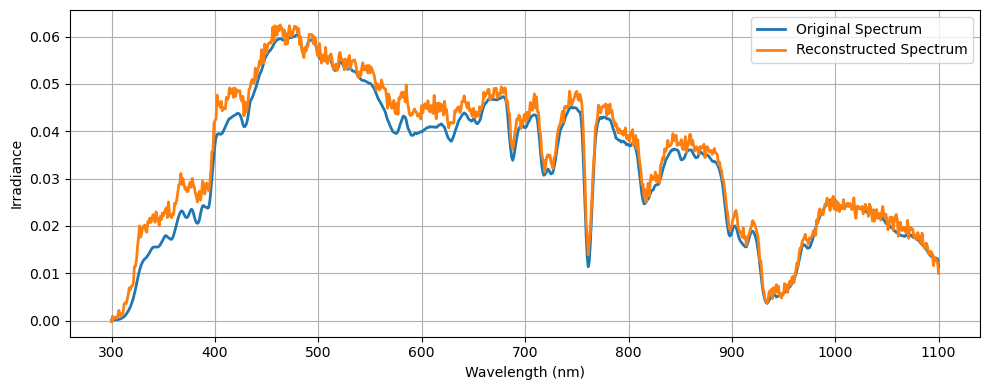

In [123]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Select one example spectrum from the dataset (e.g., index 0)
idx = 0
original = val_tensor[idx]  # shape: (801,)
original = original.unsqueeze(0).to(device)  # shape: (1, 801)

# Run through DAE to get reconstruction
model.eval()
with torch.no_grad():
    reconstructed = model(original)

# Move both to CPU and convert to numpy
original_np = original.squeeze().cpu().numpy()
reconstructed_np = reconstructed.squeeze().cpu().numpy()

# X-axis: Wavelengths from 300 to 1100 nm
wavelengths = np.linspace(300, 1100, len(original_np))

# Filter to only 1000–1100 nm region
mask = (wavelengths >= 300) & (wavelengths <= 1100)
wavelengths_zoom = wavelengths[mask]
original_zoom = original_np[mask]
reconstructed_zoom = reconstructed_np[mask]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(wavelengths_zoom, original_zoom, label='Original Spectrum', linewidth=2)
plt.plot(wavelengths_zoom, reconstructed_zoom, label='Reconstructed Spectrum', linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance')
# plt.title('Zoomed Spectrum: 1000–1100 nm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [138]:
import pandas as pd

# Load the CSV
file_path = 'dat/test/tc_2024-01-01_full_day.csv'
df = pd.read_csv(file_path)

# Keep a copy of the datetime column
if 'dt_UTC01_NoDLS' in df.columns:
    time_column = df['dt_UTC01_NoDLS']
else:
    raise ValueError("dt_UTC01_NoDLS column not found.")

# Drop datetime for processing
df_numeric = df.drop(columns='dt_UTC01_NoDLS')

# Convert to numeric and clean
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.dropna()

# Find first row where sum > 25
row_sums = df_numeric.sum(axis=1)
first_valid_idx = row_sums[row_sums > 100].index[0]

# Get the datetime for that row
timestamp = time_column[first_valid_idx]

print("Timestamp of first valid row (sum > 25):", timestamp)


Timestamp of first valid row (sum > 25): 2024-01-01 08:14:00



# save the model

In [103]:
# Save the model (recommended PyTorch way)
torch.save(model.state_dict(), "dae_model.pth")
print("Model saved to dae_model.pth")


Model saved to dae_model.pth


# load the model

In [104]:
device='cuda'
model = DAE(input_dim=801)
model.load_state_dict(torch.load("dae_model.pth", map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_5699/2109932598.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dae_model.pth", map_location=device))


DAE(
  (encoder): Sequential(
    (0): Linear(in_features=801, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=600, bias=True)
    (4): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=600, out_features=300, bias=True)
    (7): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=300, out_features=100, bias=True)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_

In [124]:
model.eval()
device = 'cuda'
model.to(device)



# Move normalized input to device
with torch.no_grad():
    latent_representations = model.encoder(val_tensor.to(device))

# Move to CPU and convert to numpy if needed
latent_representations = latent_representations.cpu()

print("Latent shape:", latent_representations.shape)  # Should be (60, 6)
print("Device", latent_representations.device)

Latent shape: torch.Size([63576, 6])
Device cpu


In [125]:
from torch.utils.data import DataLoader, TensorDataset

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

batch_size = 512  # adjust down if OOM again
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size)

all_latents = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        latent = model.encoder(x)
        all_latents.append(latent.cpu())  # keep on CPU to save GPU mem

latent_representations = torch.cat(all_latents, dim=0)
print("Latent shape:", latent_representations.shape)


Latent shape: torch.Size([68217, 6])


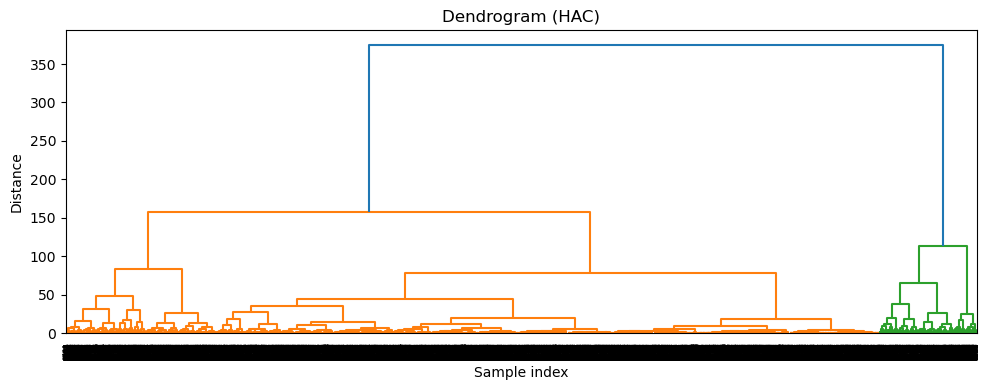

In [126]:


# Convert to numpy if not already
latent_np = latent_representations.numpy()

sampled_latent = latent_np[np.random.choice(latent_np.shape[0], size=10000, replace=False)]
# sampled_latent = latent_np

# Optional: dendrogram visualization (just for fun)
linked = linkage(sampled_latent, method='ward')
plt.figure(figsize=(10, 4))
# dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           labels=np.arange(len(sampled_latent)))

plt.title("Dendrogram (HAC)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

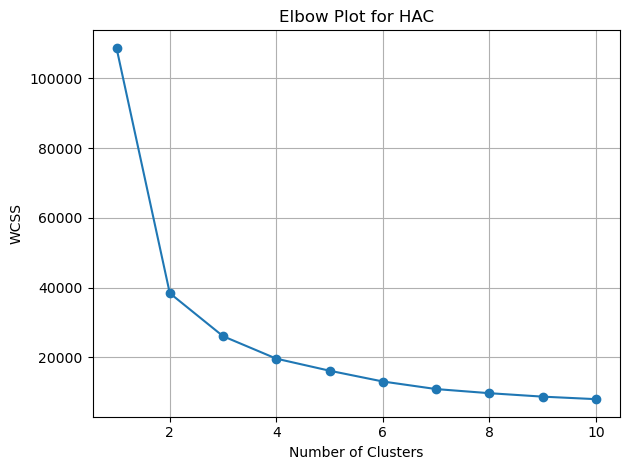

In [127]:

wcss = []
cluster_range = range(1, 11)

for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(sampled_latent)

    # Compute WCSS manually
    wcss_k = 0
    for cluster_id in np.unique(labels):
        cluster_points = sampled_latent[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        distances = np.sum((cluster_points - centroid) ** 2)
        wcss_k += distances

    wcss.append(wcss_k)

# Plot WCSS (elbow)
plt.figure()
plt.plot(cluster_range, wcss, marker='o')
plt.title("Elbow Plot for HAC")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

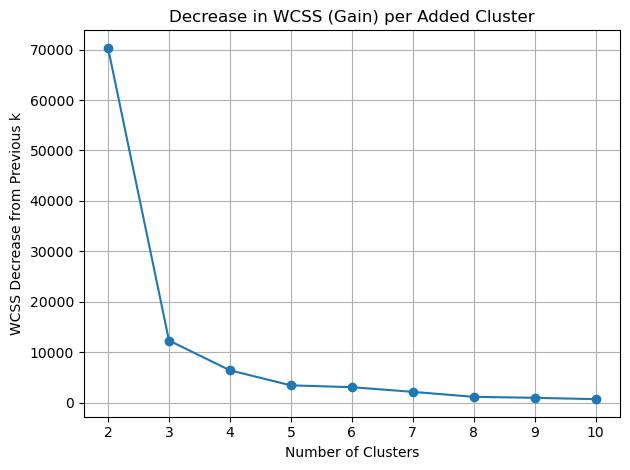

In [128]:
# Compute WCSS decrease
wcss_decrease = np.diff(wcss)  # WCSS[k] - WCSS[k+1] (so it'll be negative)

# Plot decrease in WCSS
plt.figure()
plt.plot(cluster_range[1:], -wcss_decrease, marker='o')  # negative to flip and show "decrease"
plt.title("Decrease in WCSS (Gain) per Added Cluster")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS Decrease from Previous k")
plt.grid(True)
plt.tight_layout()
plt.show()


In [142]:

# HAC with 5 clusters
hac_5 = AgglomerativeClustering(n_clusters=3)
cluster_labels = hac_5.fit_predict(sampled_latent)

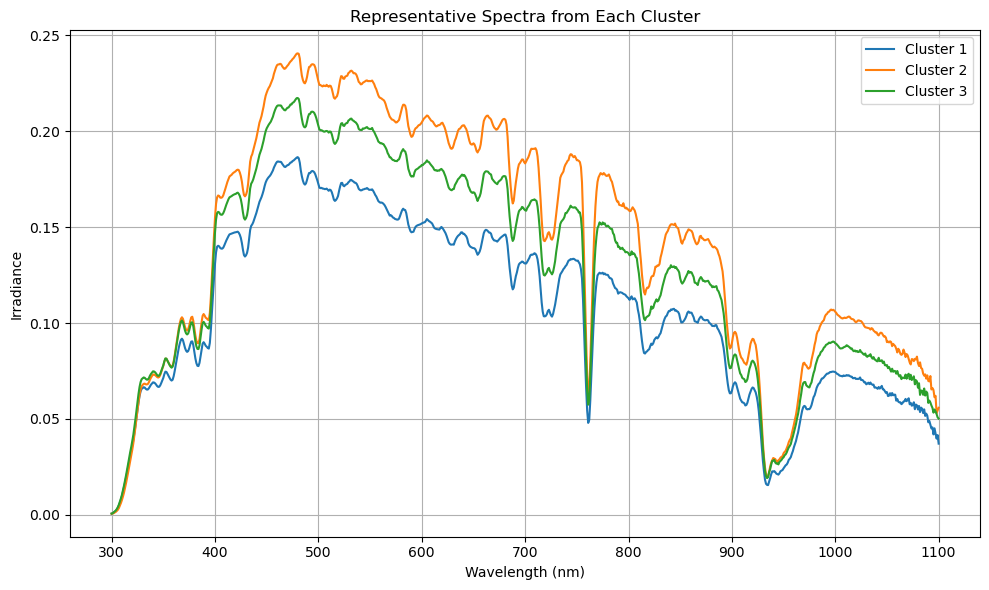

In [143]:

representative_indices = []

for cluster_id in np.unique(cluster_labels):
    # Step 1: Get indices of samples in this cluster
    cluster_idx = np.where(cluster_labels == cluster_id)[0]
    cluster_latents = latent_np[cluster_idx]

    # Step 2: Compute pairwise distances within the cluster
    pairwise_dists = cdist(cluster_latents, cluster_latents, metric='euclidean')

    # Step 3: Sum distances for each sample
    sum_dists = pairwise_dists.sum(axis=1)

    # Step 4: Select index with minimum total distance
    rep_idx_within_cluster = np.argmin(sum_dists)
    rep_idx = cluster_idx[rep_idx_within_cluster]
    representative_indices.append(rep_idx)

# Step 5: Get the corresponding original spectra (denormalized if needed)
rep_spectra = test_tensor[representative_indices].cpu().numpy()

# Step 6: Plot the representative spectra
plt.figure(figsize=(10, 6))
#wavelengths = spectra['Wavelength'].values  # original x-axis
wavelengths = np.arange(300, 1101)

for i, spec in enumerate(rep_spectra):
    plt.plot(wavelengths, spec, label=f'Cluster {i+1}')

plt.title('Representative Spectra from Each Cluster')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

green one is red-shift, because it is lower on the left of the peak amd higher on high wavelength

# Calculate APE

In [144]:
from pvlib import spectrum, solarposition, irradiance, atmosphere

In [145]:
rep_spectra_df = pd.DataFrame(rep_spectra)

In [146]:
ape = spectrum.average_photon_energy(rep_spectra_df)
ape

0    3.505097
1    3.402897
2    3.461854
dtype: float64

In [141]:
ape = spectrum.average_photon_energy(train_df)
ape

0         3.773537
1         3.789340
2         3.799936
3         3.806930
4         3.814719
            ...   
211154    3.532797
211155    3.528834
211156    3.518253
211157    3.518728
211158    3.517511
Length: 211159, dtype: float64

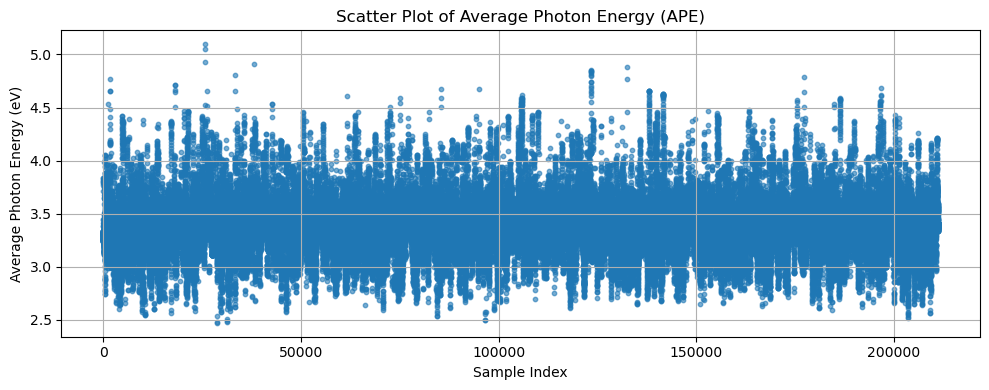

In [89]:
# If ape is a tensor or array, convert to numpy
ape_np = ape.cpu().numpy() if hasattr(ape, 'cpu') else np.array(ape)

# Scatter plot: index vs APE
plt.figure(figsize=(10, 4))
plt.scatter(range(len(ape_np)), ape_np, alpha=0.6, s=10)
plt.xlabel("Sample Index")
plt.ylabel("Average Photon Energy (eV)")
plt.title("Scatter Plot of Average Photon Energy (APE)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Run this cell, my computer crashes when i try

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load all CSVs from the 'dat/train' directory
data_dir = "dat/test"
all_dfs = []

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        all_dfs.append(df)

# Concatenate all dataframes
full_df = pd.concat(all_dfs, ignore_index=True)

# Calculate row-wise irradiance (sum across wavelengths)
irradiance = full_df.sum(axis=1)

# Define bin edges in steps of 50 from 0 to the max irradiance rounded up to the next multiple of 50
max_irr = int(np.ceil(irradiance.max() / 50.0) * 50)
bins = np.arange(0, max_irr + 50, 50)

# Compute histogram
counts, edges = np.histogram(irradiance, bins=bins)
percentages = 100 * counts / counts.sum()

# Generate bin labels
bin_labels = [f"{int(edges[i])}-{int(edges[i+1])}" for i in range(len(edges)-1)]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(bin_labels, percentages, width=0.8)
plt.xlabel("Irradiance (W/m²)")
plt.ylabel("Spectra frequency (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
